# **Importing Libraries**
Importing the necessary libraries required for the project.
One interesting library we have imported is dask-ml which provides scalable machine learning in Python using Dask alongside popular machine learning libraries like Scikit-Learn, XGBoost, and others.

In [1]:

import numpy as np 
import pandas as pd 
import dask.dataframe as dd
from sklearn.preprocessing import MinMaxScaler
# from sklearn.feature_selection import VarianceThreshold
# from sklearn.feature_selection import SelectKBest,SelectPercentile
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from sklearn import svm

pd.set_option("display.max_rows", 100, "display.max_columns", 100)
!pip install dask-ml

from sklearn.linear_model import SGDClassifier,Perceptron


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.5/148.5 kB 679.8 kB/s eta 0:00:00a 0:00:01


In [2]:
import os
os.chdir('/kaggle/working')
import dask_ml.model_selection as dcv
from dask_ml.wrappers import Incremental

In [3]:
def nanVal(df):
    pd.options.mode.use_inf_as_na = True
    df.dropna(axis=0,inplace=True)
    return df    

def nanValTest(df):
    pd.options.mode.use_inf_as_na = True
    df.fillna(0,inplace=True)
    return df

# Downcasting data types(implicit conversion based on Max values)
The below function reduces the datasize based on the min and max max values of columns and changing the datatype of column to suitable datatype 

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

# Importing data 
Importing train data using above function

In [5]:
#Train Data import
df = import_data('../input/network-incursion-prediction/true_train_df.csv')
print(df.shape)
print("Data read successfull")

Memory usage of dataframe is 9261.00 MB
Memory usage after optimization is: 3660.99 MB
Decreased by 60.5%
(15173222, 80)
Data read successfull


Importing test data using above function

In [6]:
#Test data import
dft = import_data('../input/network-incursion-prediction/test_togive.csv')
print(dft.shape)
print("Data read successfull")

Memory usage of dataframe is 602.72 MB
Memory usage after optimization is: 236.51 MB
Decreased by 60.8%
(1000000, 79)
Data read successfull


# Dropping columns based on Data exploration and analysis
Below columns are such that they have one unique value 

In [7]:
#Defining columns to be dropped based on data Exploration and Analysis
dropp = ["index","Bwd PSH Flags","Bwd URG Flags","Fwd Byts/b Avg","Fwd Pkts/b Avg","Fwd Blk Rate Avg","Bwd Byts/b Avg",
         "Bwd Pkts/b Avg","Bwd Blk Rate Avg","FIN Flag Cnt","CWE Flag Count","Fwd URG Flags"]
#Watchout - here we have removed Dst Port just to check for better accuarcy
df = df.drop(dropp,axis=1)
dft = dft.drop(dropp,axis=1)

Changing data type implicitly of some columns which have integer values

In [8]:
# columns explicitly being converted to int8 based on their max values
flagColumns=['Protocol','Fwd PSH Flags','SYN Flag Cnt','RST Flag Cnt','PSH Flag Cnt','ACK Flag Cnt','URG Flag Cnt','ECE Flag Cnt']
y = df['Label']
for i in flagColumns:
    df[i] = df[i].astype(np.int8)
for i in flagColumns:
    dft[i] = dft[i].astype(np.int8)    

In [9]:
df.info()
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15173222 entries, 0 to 15173221
Data columns (total 68 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           float32
 1   Protocol           int8   
 2   Flow Duration      float32
 3   Tot Fwd Pkts       float32
 4   Tot Bwd Pkts       float32
 5   TotLen Fwd Pkts    float32
 6   TotLen Bwd Pkts    float32
 7   Fwd Pkt Len Max    float16
 8   Fwd Pkt Len Min    float16
 9   Fwd Pkt Len Mean   float16
 10  Fwd Pkt Len Std    float16
 11  Bwd Pkt Len Max    float16
 12  Bwd Pkt Len Min    float16
 13  Bwd Pkt Len Mean   float16
 14  Bwd Pkt Len Std    float16
 15  Flow Byts/s        float64
 16  Flow Pkts/s        float64
 17  Flow IAT Mean      float32
 18  Flow IAT Std       float32
 19  Flow IAT Max       float32
 20  Flow IAT Min       float32
 21  Fwd IAT Tot        float32
 22  Fwd IAT Mean       float32
 23  Fwd IAT Std        float32
 24  Fwd IAT Max        float32
 25  Fwd IAT Min     

# Removing NaN and Infinite values from dataframe

In [10]:
# To remove infinity and nan values
df = nanVal(df)
dft = nanValTest(dft)

In [11]:
# Checking whether there are any infinite or nan values remaining or not
countINF = [0,0]
countINF[0] = np.isinf(df).values.sum()

countINF[1] = np.isinf(dft).values.sum()
countINF



[0, 0]

In [12]:
countNA = [0,0]
countNA[0] = df.isna().sum()

countNA[1] = df.isna().sum()
countNA

[Dst Port             0
 Protocol             0
 Flow Duration        0
 Tot Fwd Pkts         0
 Tot Bwd Pkts         0
 TotLen Fwd Pkts      0
 TotLen Bwd Pkts      0
 Fwd Pkt Len Max      0
 Fwd Pkt Len Min      0
 Fwd Pkt Len Mean     0
 Fwd Pkt Len Std      0
 Bwd Pkt Len Max      0
 Bwd Pkt Len Min      0
 Bwd Pkt Len Mean     0
 Bwd Pkt Len Std      0
 Flow Byts/s          0
 Flow Pkts/s          0
 Flow IAT Mean        0
 Flow IAT Std         0
 Flow IAT Max         0
 Flow IAT Min         0
 Fwd IAT Tot          0
 Fwd IAT Mean         0
 Fwd IAT Std          0
 Fwd IAT Max          0
 Fwd IAT Min          0
 Bwd IAT Tot          0
 Bwd IAT Mean         0
 Bwd IAT Std          0
 Bwd IAT Max          0
 Bwd IAT Min          0
 Fwd PSH Flags        0
 Fwd Header Len       0
 Bwd Header Len       0
 Fwd Pkts/s           0
 Bwd Pkts/s           0
 Pkt Len Min          0
 Pkt Len Max          0
 Pkt Len Mean         0
 Pkt Len Std          0
 Pkt Len Var          0
 SYN Flag Cnt   

In [13]:
df.describe()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,15139506.0,15139506.0,15139506.0,1.513951e+07,15139506.0,15139506.0,15139506.0,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,15139506.0,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,15139506.0,15139506.0,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,15139506.0,1.513951e+07,15139506.0,15139506.0,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,15139506.0,1.513951e+07,15139506.00,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07,1.513951e+07
mean,8.920302e+03,8.770257e+00,1.192173e+07,2.358937e+01,6.334103e+00,9.783180e+02,4.733595e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.571235e+05,5.229599e+04,3.350912e+06,1.277130e+06,6.622326e+06,2.350415e+06,1.162917e+07,3.678782e+06,1.405348e+06,6.428020e+06,2.438774e+06,7644946.5,8.292751e+05,8.566812e+05,2.630000e+06,2.929795e+05,4.194595e-02,2.580273e+02,1.335549e+02,3.688653e+04,1.540948e+04,NaN,NaN,NaN,NaN,4.142255e+04,4.194595e-02,1.885040e-01,3.943735e-01,3.281626e-01,4.196398e-02,1.885044e-01,NaN,NaN,NaN,NaN,2.358937e+01,9.783180e+02,6.334103e+00,4.733570e+03,8.829056e+03,8.740440e+03,1.995193e+01,NaN,1.736565e+05,86757.25,2.635966e+05,1.160454e+05,5.043110e+06,2.847675e+05,5.444496e+06,4.715054e+06,1.702227e-01
std,1.869812e+04,4.929923e+00,4.536766e+08,1.520510e+03,1.640832e+02,6.301675e+04,2.343418e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.685286e+06,2.647132e+05,2.308127e+08,3.359740e+08,6.547615e+08,7.403457e+08,4.536709e+08,2.308242e+08,3.359806e+08,6.547595e+08,7.403487e+08,25938032.0,4.352960e+06,3.387310e+06,1.027642e+07,3.836732e+06,2.004657e-01,1.224547e+04,3.265482e+03,2.139045e+05,9.269948e+04,NaN,NaN,NaN,NaN,2.195930e+05,2.004657e-01,3.911141e-01,4.887157e-01,4.695444e-01,2.005069e-01,3.911145e-01,NaN,NaN,NaN,NaN,1.520510e+03,6.301675e+04,1.640832e+02,2.343307e+05,1.626556e+04,2.066945e+04,1.519331e+03,0.0,2.510511e+06,1515900.00,3.324652e+06,2.118788e+06,2.626700e+08,1.680112e+08,6.178034e+08,6.570454e+07,3.758283e-01
min,0.000000e+00,0.000000e+00,-8.282200e+11,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,-8.895325e-03,-8.282200e+11,0.000000e+00,-8.282200e+11,-9.474050e+11,-8.282200e+11,-8.282200e+11,0.000000e+00,-8.282200e+11,-9.474050e+11,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.0,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0

# Dealing with negative values
Handling negative values in 2 ways:
1. Columns having negative values can be replaced with 0 (These are columns in which negative values makes no sense)
2. Columns having negative values can be standardised by shifting with min values(These are columns in which negative values makes sense)

In [14]:
#Columns which can be replaced with 0 = Init Fwd Win Byts,Init Bwd Win Byts, Flow Pkts/s = No of data packets,Flow Duration= Length of duration in seconds
canReplace = ["Init Fwd Win Byts","Init Bwd Win Byts","Flow Pkts/s","Flow Duration"]
for col in canReplace:
    df[col]=df[col].mask(df[col].lt(0),0)
    dft[col]=dft[col].mask(dft[col].lt(0),0)
#Columns which needs to be standardised by shifting with min value = Fwd IAT Max,Fwd IAT Min, Flow IAT Mean,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min
needsToBeShifted = ["Fwd IAT Max","Fwd IAT Min", "Flow IAT Mean","Flow IAT Max","Flow IAT Min","Fwd IAT Tot","Fwd IAT Mean","Fwd IAT Std","Fwd IAT Max","Fwd IAT Min"]

for col in needsToBeShifted:
    df[col] = df[col] + np.absolute(df[col].min())
    dft[col] = dft[col] + np.absolute(dft[col].min())

# Outliers Removal
Outlier removal using zscore

In [15]:
#Outlier detection
# Z score determines if a data value is greater or smaller than mean and how far away it is from mean
#z score = (pt - mean)/StdDevn
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(df))
print(np.where(z>3))

(array([       2,        3,        5, ..., 15139501, 15139501, 15139503]), array([55, 55, 45, ..., 16, 34, 55]))


In [16]:
df.shape


(15139506, 68)

In [17]:
df['Label'].value_counts()

0    12562419
1     2577087
Name: Label, dtype: int64

In [18]:
df = df[(z < 3).all(axis=1)]

In [19]:
df.shape

(11008504, 68)

In [20]:
df['Label'].value_counts()

0    9000874
1    2007630
Name: Label, dtype: int64

array([[<AxesSubplot:title={'center':'Dst Port'}>,
        <AxesSubplot:title={'center':'Protocol'}>,
        <AxesSubplot:title={'center':'Flow Duration'}>,
        <AxesSubplot:title={'center':'Tot Fwd Pkts'}>,
        <AxesSubplot:title={'center':'Tot Bwd Pkts'}>,
        <AxesSubplot:title={'center':'TotLen Fwd Pkts'}>,
        <AxesSubplot:title={'center':'TotLen Bwd Pkts'}>,
        <AxesSubplot:title={'center':'Fwd Pkt Len Max'}>],
       [<AxesSubplot:title={'center':'Fwd Pkt Len Min'}>,
        <AxesSubplot:title={'center':'Fwd Pkt Len Mean'}>,
        <AxesSubplot:title={'center':'Fwd Pkt Len Std'}>,
        <AxesSubplot:title={'center':'Bwd Pkt Len Max'}>,
        <AxesSubplot:title={'center':'Bwd Pkt Len Min'}>,
        <AxesSubplot:title={'center':'Bwd Pkt Len Mean'}>,
        <AxesSubplot:title={'center':'Bwd Pkt Len Std'}>,
        <AxesSubplot:title={'center':'Flow Byts/s'}>],
       [<AxesSubplot:title={'center':'Flow Pkts/s'}>,
        <AxesSubplot:title={'center':'Fl

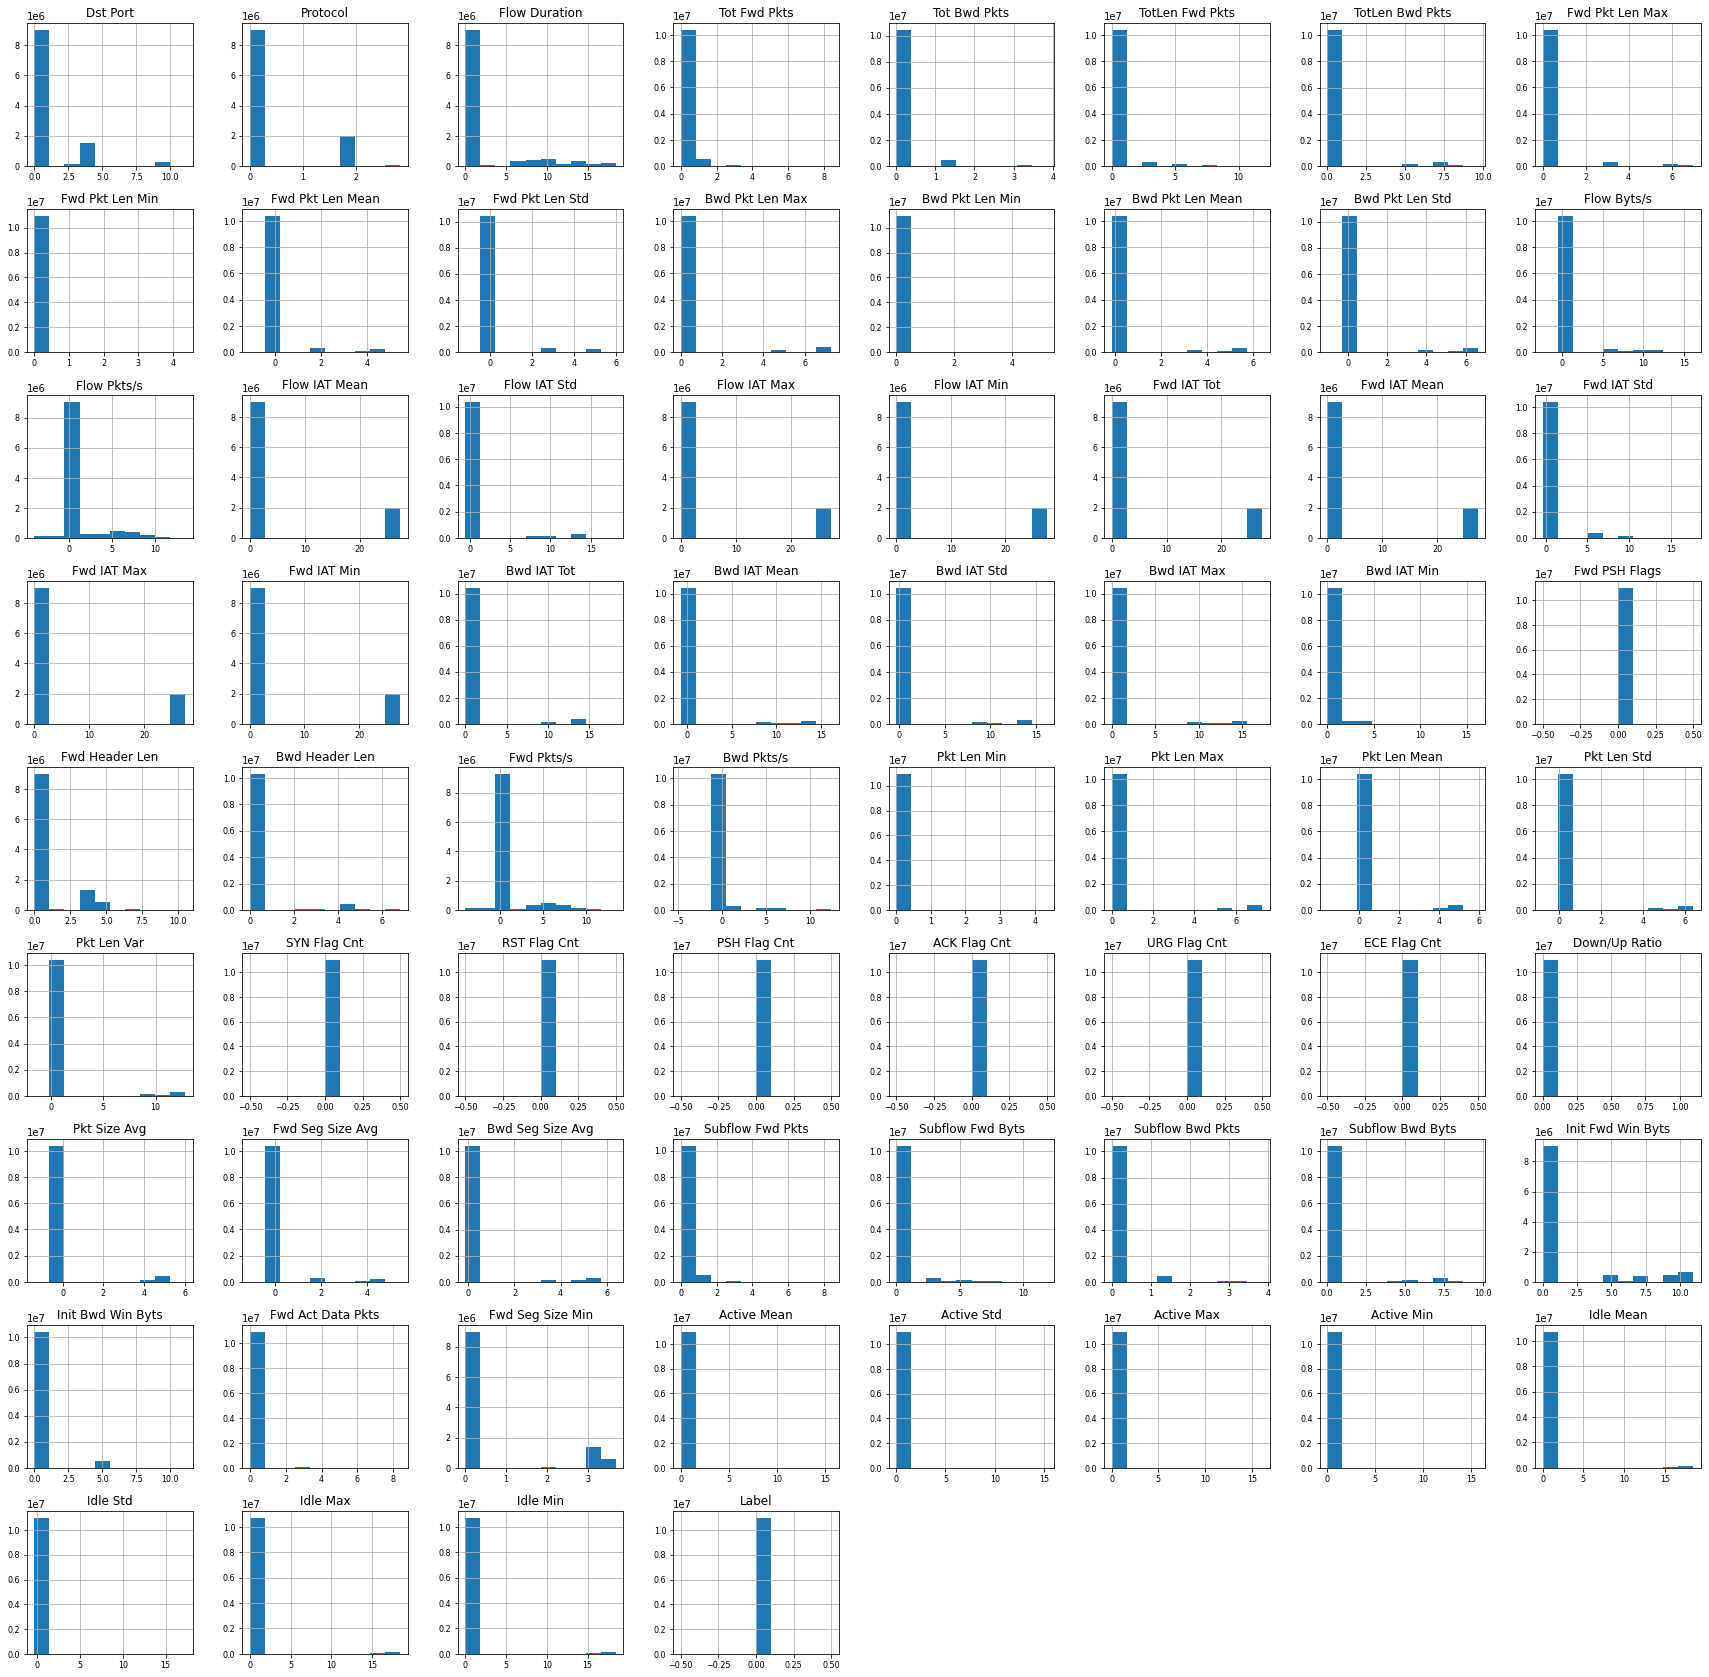

In [21]:

((pd.DataFrame(np.log(df.where(df['Label']==1)))).replace(-np.Inf,0)).hist(figsize=(30,30),xlabelsize=8,ylabelsize=8)

array([[<AxesSubplot:title={'center':'Dst Port'}>,
        <AxesSubplot:title={'center':'Protocol'}>,
        <AxesSubplot:title={'center':'Flow Duration'}>,
        <AxesSubplot:title={'center':'Tot Fwd Pkts'}>,
        <AxesSubplot:title={'center':'Tot Bwd Pkts'}>,
        <AxesSubplot:title={'center':'TotLen Fwd Pkts'}>,
        <AxesSubplot:title={'center':'TotLen Bwd Pkts'}>,
        <AxesSubplot:title={'center':'Fwd Pkt Len Max'}>],
       [<AxesSubplot:title={'center':'Fwd Pkt Len Min'}>,
        <AxesSubplot:title={'center':'Fwd Pkt Len Mean'}>,
        <AxesSubplot:title={'center':'Fwd Pkt Len Std'}>,
        <AxesSubplot:title={'center':'Bwd Pkt Len Max'}>,
        <AxesSubplot:title={'center':'Bwd Pkt Len Min'}>,
        <AxesSubplot:title={'center':'Bwd Pkt Len Mean'}>,
        <AxesSubplot:title={'center':'Bwd Pkt Len Std'}>,
        <AxesSubplot:title={'center':'Flow Byts/s'}>],
       [<AxesSubplot:title={'center':'Flow Pkts/s'}>,
        <AxesSubplot:title={'center':'Fl

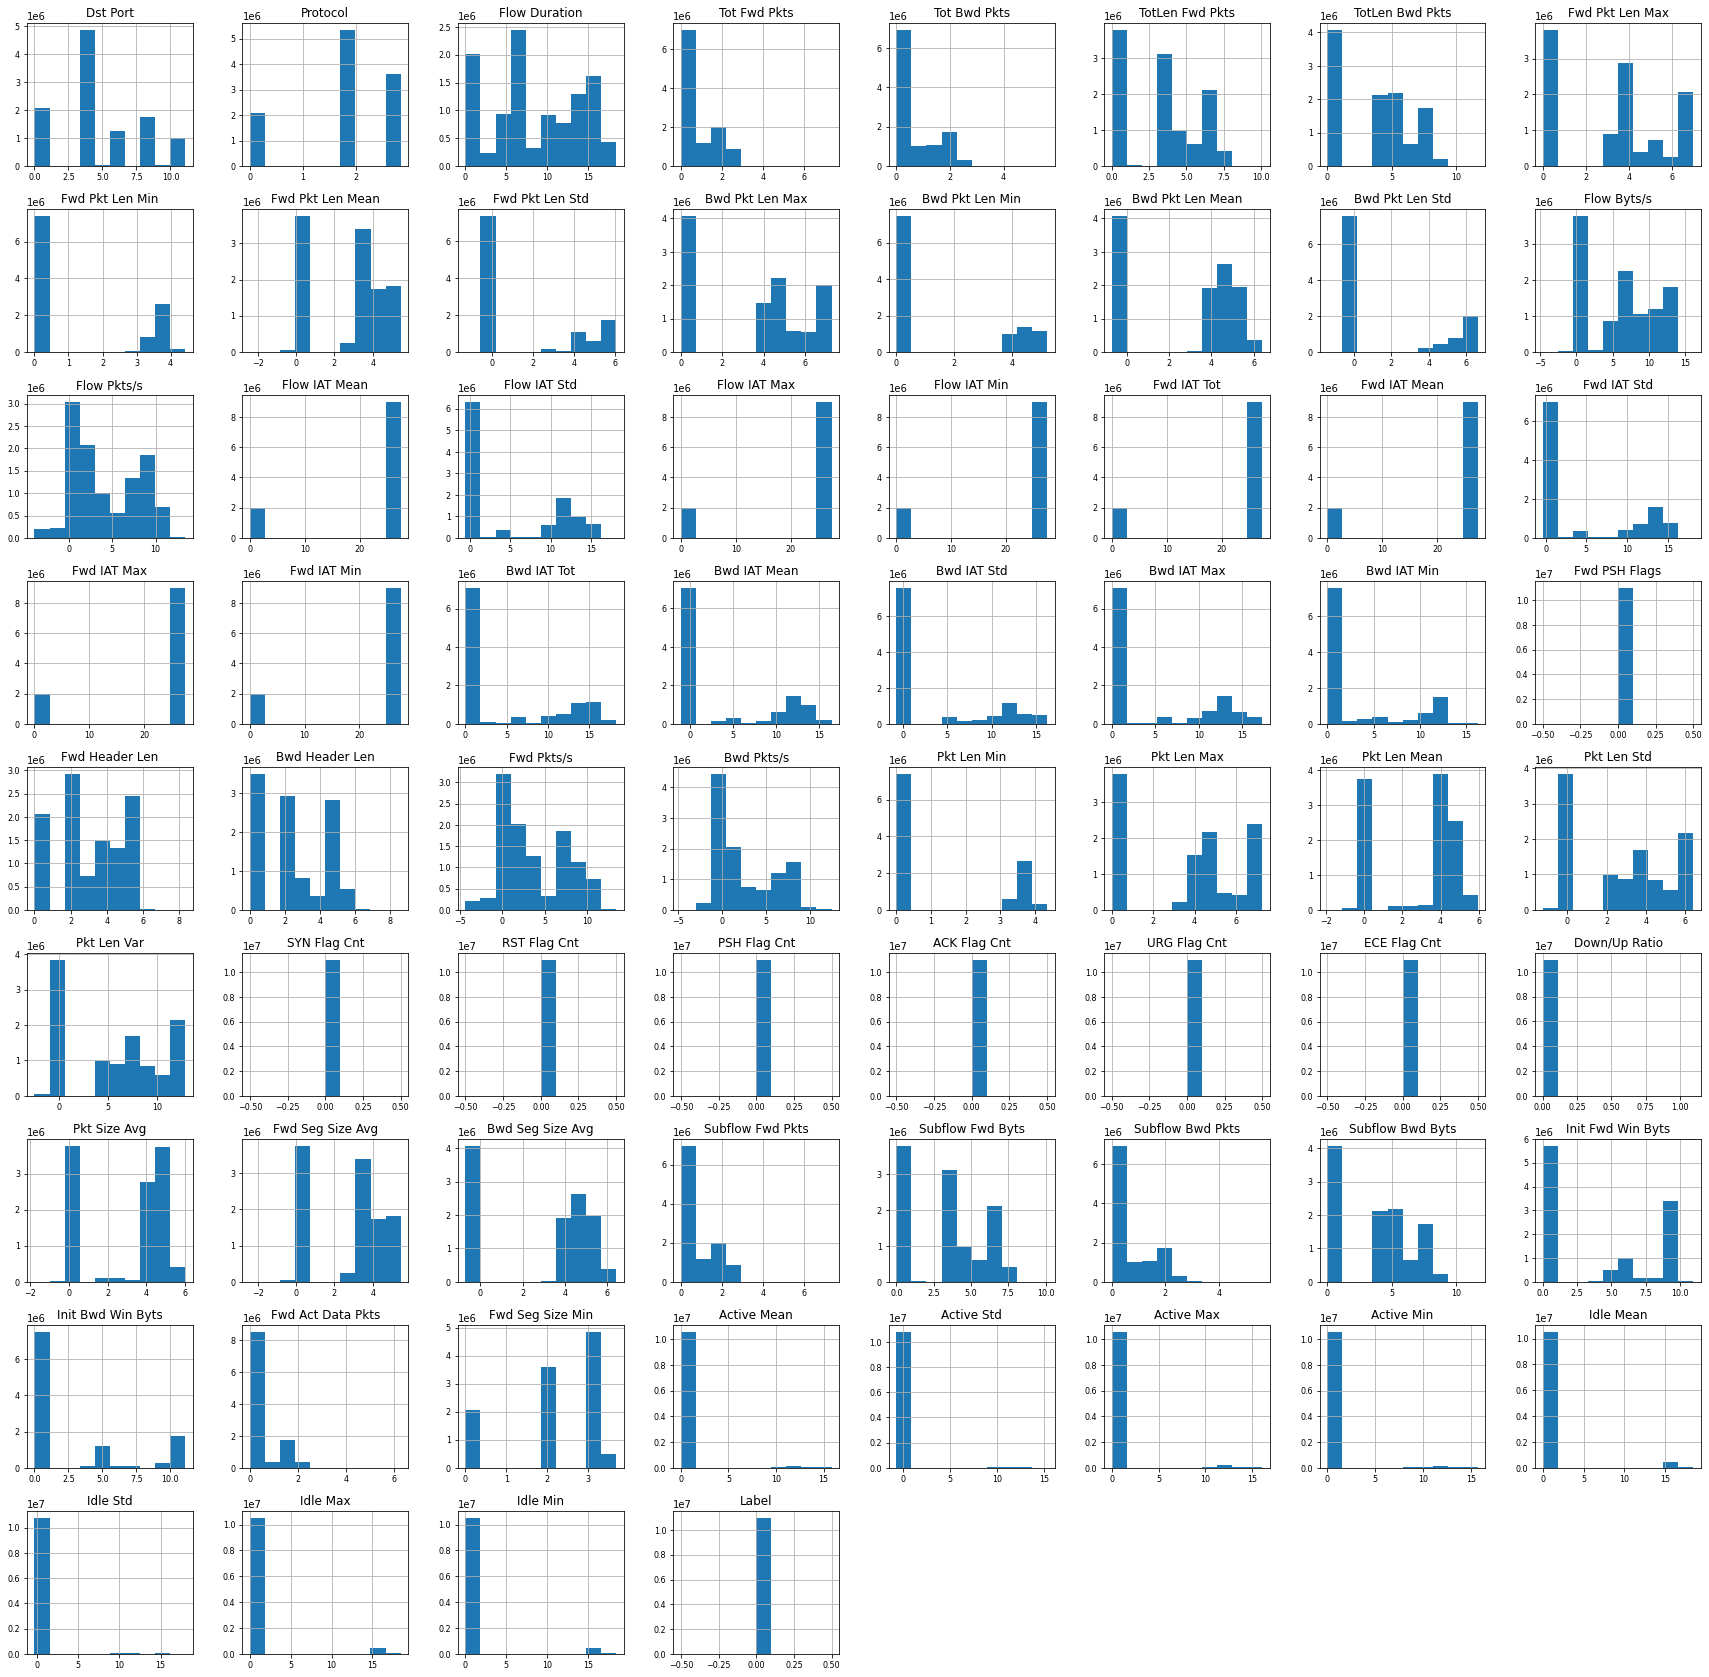

In [22]:
((pd.DataFrame(np.log(df.where(df['Label']==0)))).replace(-np.Inf,0)).hist(figsize=(30,30),xlabelsize=8,ylabelsize=8)

In [23]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        if feature_name != 'Label':
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result
df = normalize(df)
dft = normalize(dft)

In [24]:
df.describe()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,0.0,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,0.0,1.100850e+07,1.100850e+07,1.100850e+07,0.0,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07
mean,8.494320e-02,5.651926e-01,3.454439e-02,6.271499e-04,1.016094e-02,2.105832e-03,4.249786e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.802658e-03,9.452674e-03,1.645141e-02,4.779287e-03,2.424372e-02,1.480654e-02,3.218153e-02,1.723598e-02,4.610639e-03,2.258987e-02,1.504438e-02,1.899883e-02,1.776449e-02,2.494432e-02,1.965338e-02,4.463757e-03,NaN,2.258971e-03,1.094554e-02,7.317188e-03,5.694646e-03,NaN,NaN,NaN,NaN,8.163076e-02,NaN,1.688621e-01,3.710142e-01,2.895862e-01,NaN,1.688607e-01,NaN,NaN,NaN,NaN,6.271499e-04,2.105832e-03,1.016094e-02,4.249786e-03,8.762153e-02,1.536586e-01,3.307697e-04,NaN,3.015450e-03,1.158834e-03,2.948326e-03,3.008656e-03,9.860856e-03,2.961515e-04,1.001135e-02,9.703341e-03,1.823708e-01
std,2.246842e-01,3.068835e-01,1.069548e-01,1.540244e-03,1.294123e-02,3.486654e-03,7.952378e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.917233e-02,3.884832e-02,7.916299e-02,2.033017e-02,8.395284e-02,7.893677e-02,1.053287e-01,7.932262e-02,1.772157e-02,8.297777e-02,7.923765e-02,8.302305e-02,6.096205e-02,8.040716e-02,5.996840e-02,3.998747e-02,NaN,2.848652e-03,1.686189e-02,2.776986e-02,4.189431e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.433314e-01,NaN,3.746301e-01,4.830763e-01,4.535703e-01,NaN,3.746289e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.540244e-03,3.486654e-03,1.294123e-02,7.952378e-03,1.364997e-01,3.443035e-01,1.076994e-03,0.000000e+00,3.153782e-02,1.994021e-02,2.823496e-02,3.487574e-02,5.037463e-02,8.048411e-03,5.108100e-02,5.000274e-02,3.861499e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0

# Visualizing data using Pie chart and histograms


In [25]:
df['Label'].value_counts()

0    9000874
1    2007630
Name: Label, dtype: int64

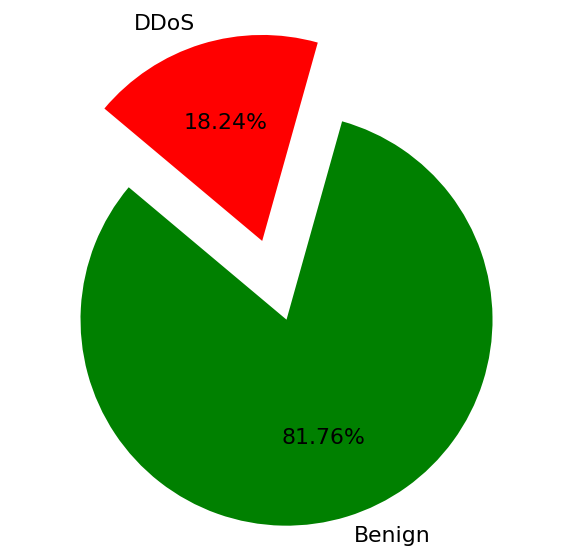

In [26]:
labels = ['Benign','DDoS']
sizes = [len(df[df['Label'] == 0]),len(df[df['Label'] == 1])]
colors = ['green','red']
explode = (0.3,0.1)

plt.rcParams.update({'font.size':22})
plt.figure(figsize=(10,10))
plt.pie(sizes,explode = explode,labels = labels,colors = colors,
       autopct = '%1.2f%%',startangle = 140)

plt.axis('equal')
plt.show()

Below chart shows that most of the attacks were on TCP which is quite surprising

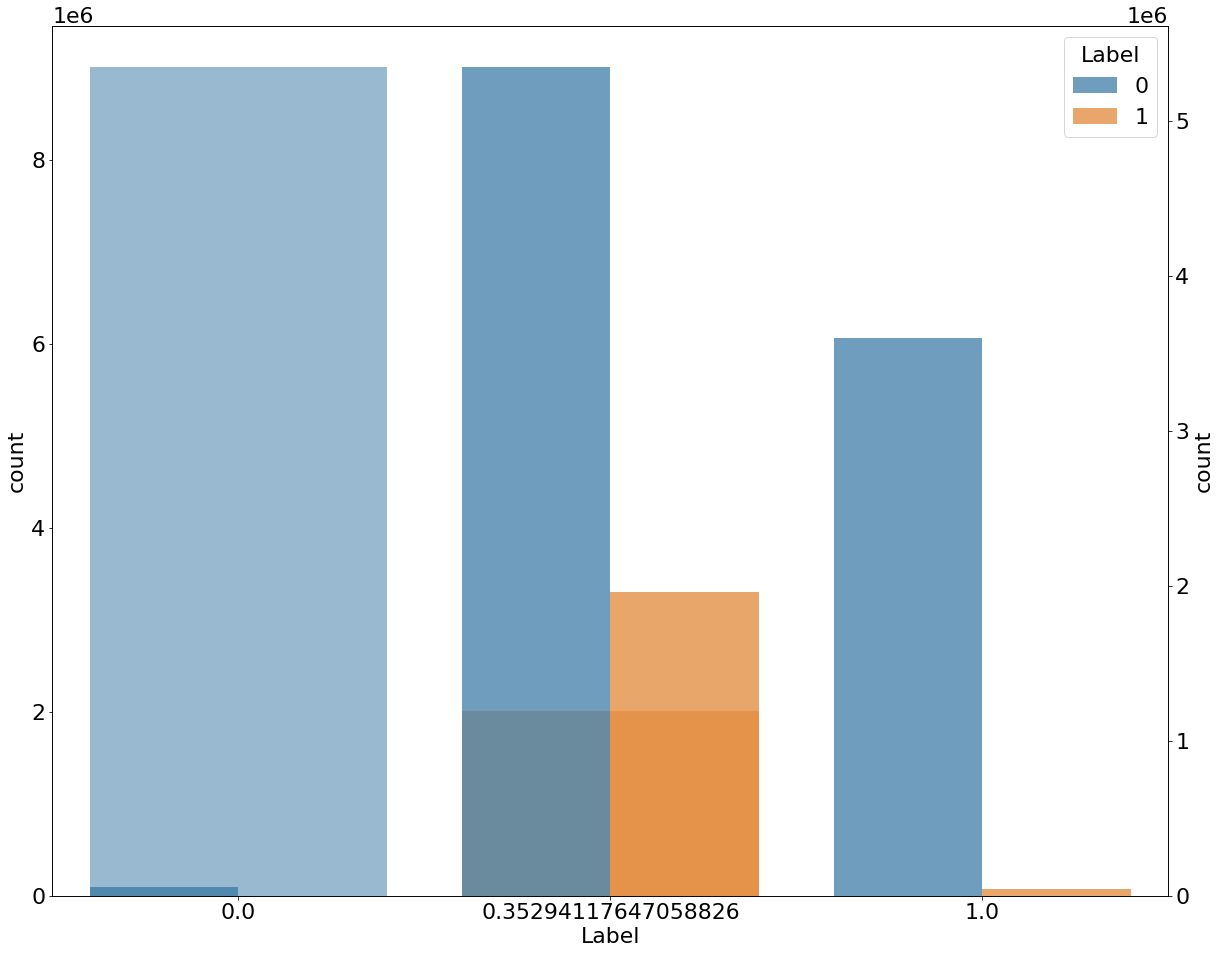

In [27]:
import seaborn as sns
plt.figure(figsize =(20,16))
g1 = sns.countplot(x='Label',data = df,alpha=0.5)
gt = g1.twinx()
gt = sns.countplot(x='Protocol',hue='Label',alpha=0.7,data = df)

array([[<AxesSubplot:title={'center':'Dst Port'}>,
        <AxesSubplot:title={'center':'Protocol'}>,
        <AxesSubplot:title={'center':'Flow Duration'}>,
        <AxesSubplot:title={'center':'Tot Fwd Pkts'}>,
        <AxesSubplot:title={'center':'Tot Bwd Pkts'}>,
        <AxesSubplot:title={'center':'TotLen Fwd Pkts'}>,
        <AxesSubplot:title={'center':'TotLen Bwd Pkts'}>,
        <AxesSubplot:title={'center':'Fwd Pkt Len Max'}>],
       [<AxesSubplot:title={'center':'Fwd Pkt Len Min'}>,
        <AxesSubplot:title={'center':'Fwd Pkt Len Mean'}>,
        <AxesSubplot:title={'center':'Fwd Pkt Len Std'}>,
        <AxesSubplot:title={'center':'Bwd Pkt Len Max'}>,
        <AxesSubplot:title={'center':'Bwd Pkt Len Min'}>,
        <AxesSubplot:title={'center':'Bwd Pkt Len Mean'}>,
        <AxesSubplot:title={'center':'Bwd Pkt Len Std'}>,
        <AxesSubplot:title={'center':'Flow Byts/s'}>],
       [<AxesSubplot:title={'center':'Flow Pkts/s'}>,
        <AxesSubplot:title={'center':'Fl

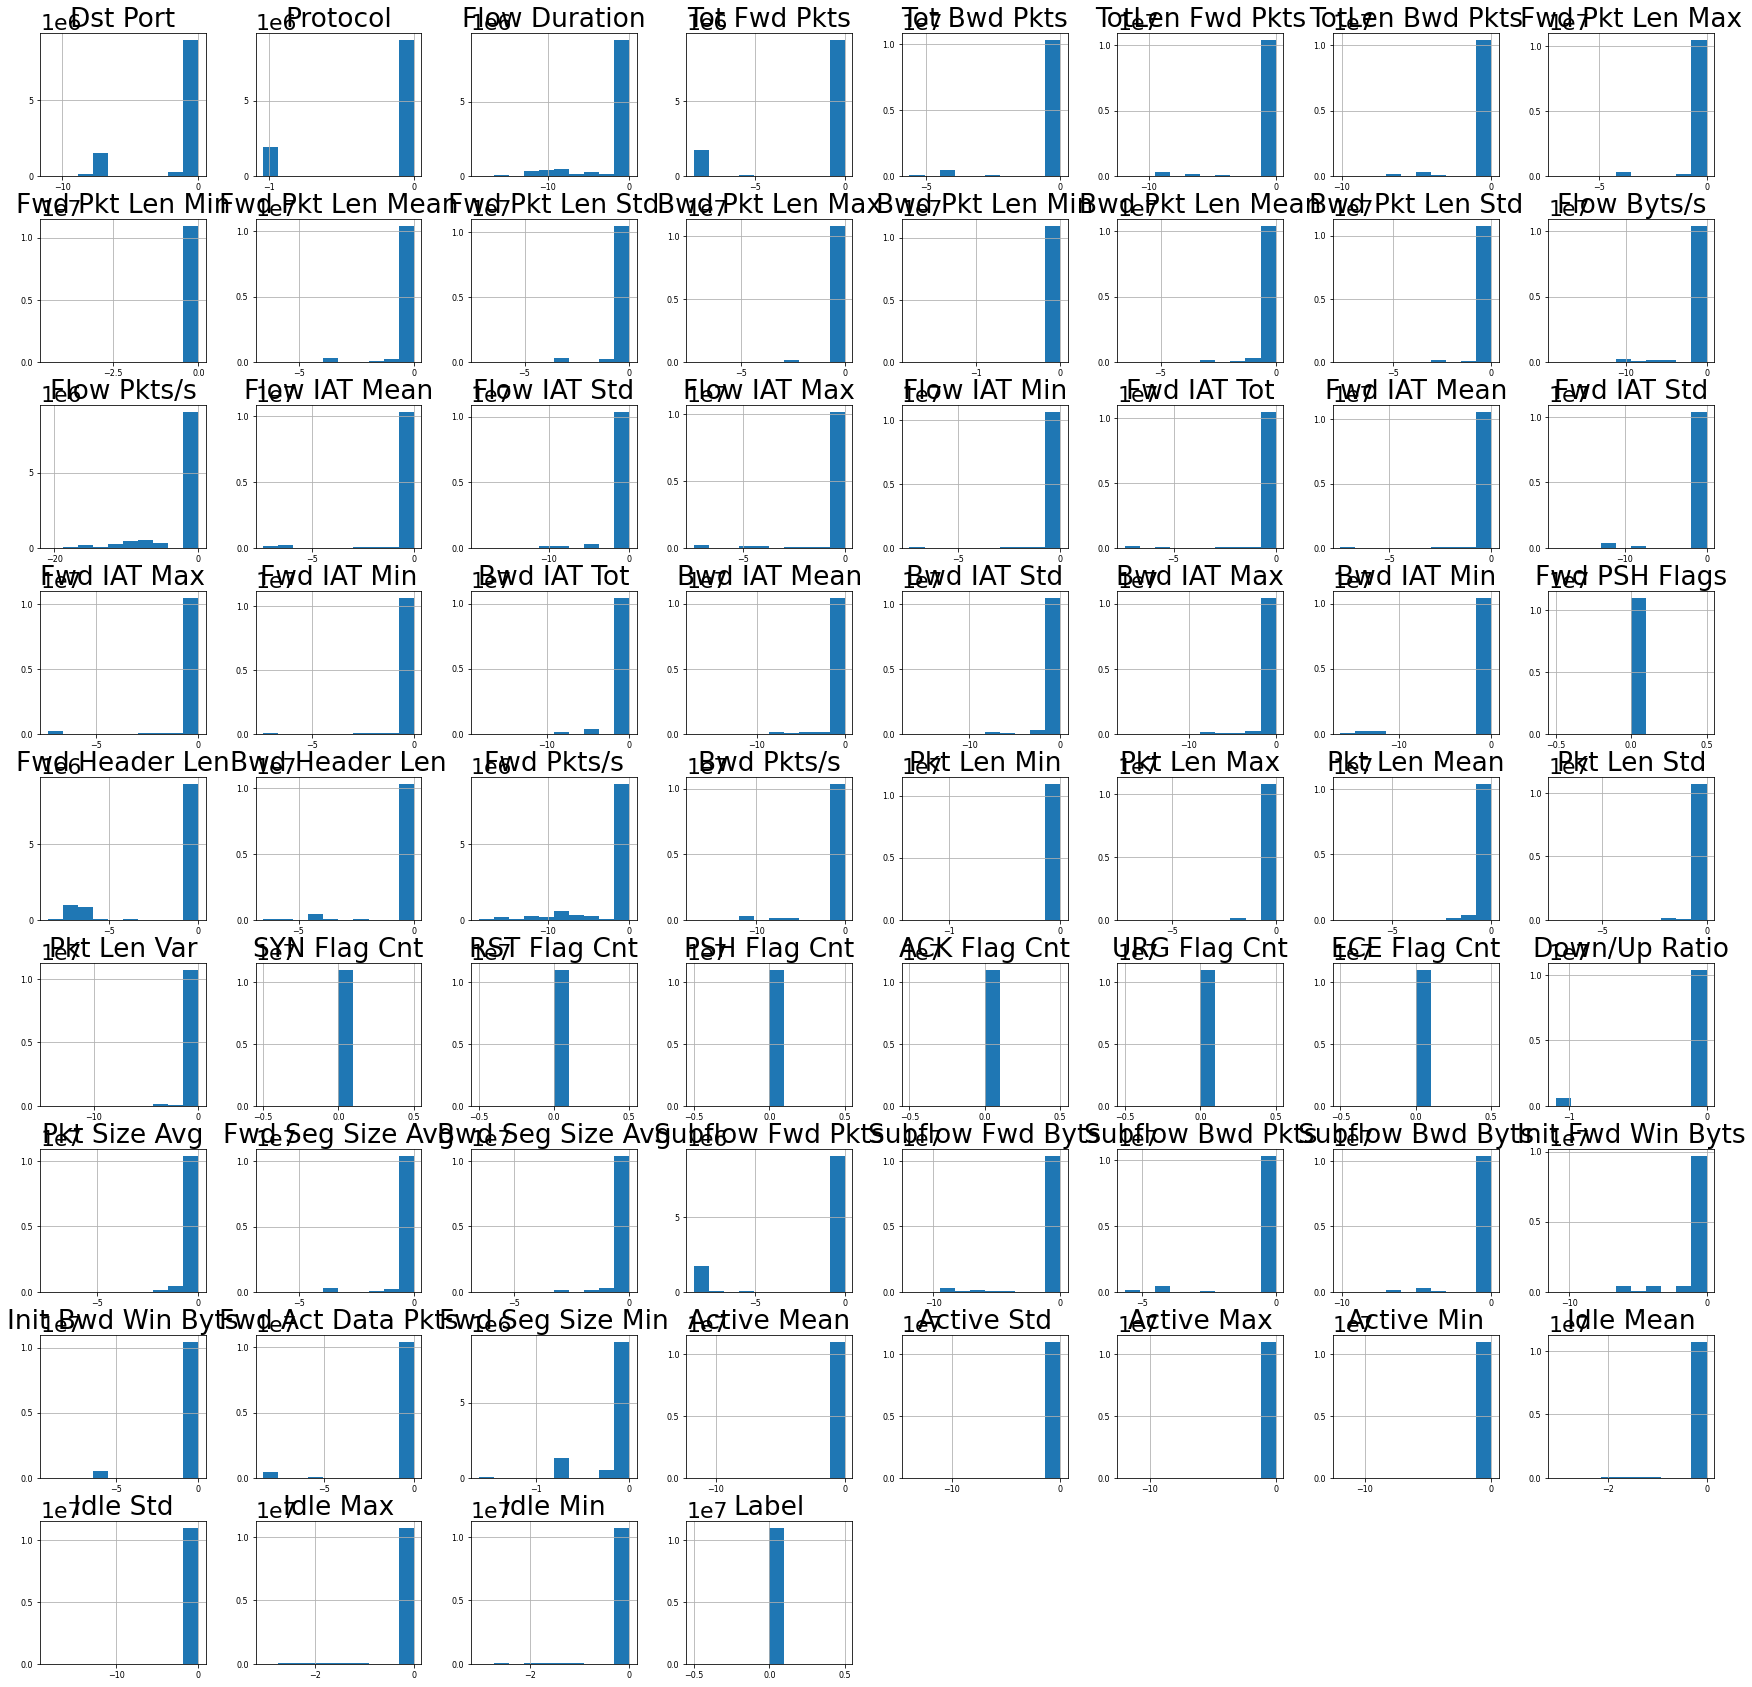

In [28]:
((pd.DataFrame(np.log(df.where(df['Label']==1)))).replace(-np.Inf,0)).hist(figsize=(30,30),xlabelsize=8,ylabelsize=8)


array([[<AxesSubplot:title={'center':'Dst Port'}>,
        <AxesSubplot:title={'center':'Protocol'}>,
        <AxesSubplot:title={'center':'Flow Duration'}>,
        <AxesSubplot:title={'center':'Tot Fwd Pkts'}>,
        <AxesSubplot:title={'center':'Tot Bwd Pkts'}>,
        <AxesSubplot:title={'center':'TotLen Fwd Pkts'}>,
        <AxesSubplot:title={'center':'TotLen Bwd Pkts'}>,
        <AxesSubplot:title={'center':'Fwd Pkt Len Max'}>],
       [<AxesSubplot:title={'center':'Fwd Pkt Len Min'}>,
        <AxesSubplot:title={'center':'Fwd Pkt Len Mean'}>,
        <AxesSubplot:title={'center':'Fwd Pkt Len Std'}>,
        <AxesSubplot:title={'center':'Bwd Pkt Len Max'}>,
        <AxesSubplot:title={'center':'Bwd Pkt Len Min'}>,
        <AxesSubplot:title={'center':'Bwd Pkt Len Mean'}>,
        <AxesSubplot:title={'center':'Bwd Pkt Len Std'}>,
        <AxesSubplot:title={'center':'Flow Byts/s'}>],
       [<AxesSubplot:title={'center':'Flow Pkts/s'}>,
        <AxesSubplot:title={'center':'Fl

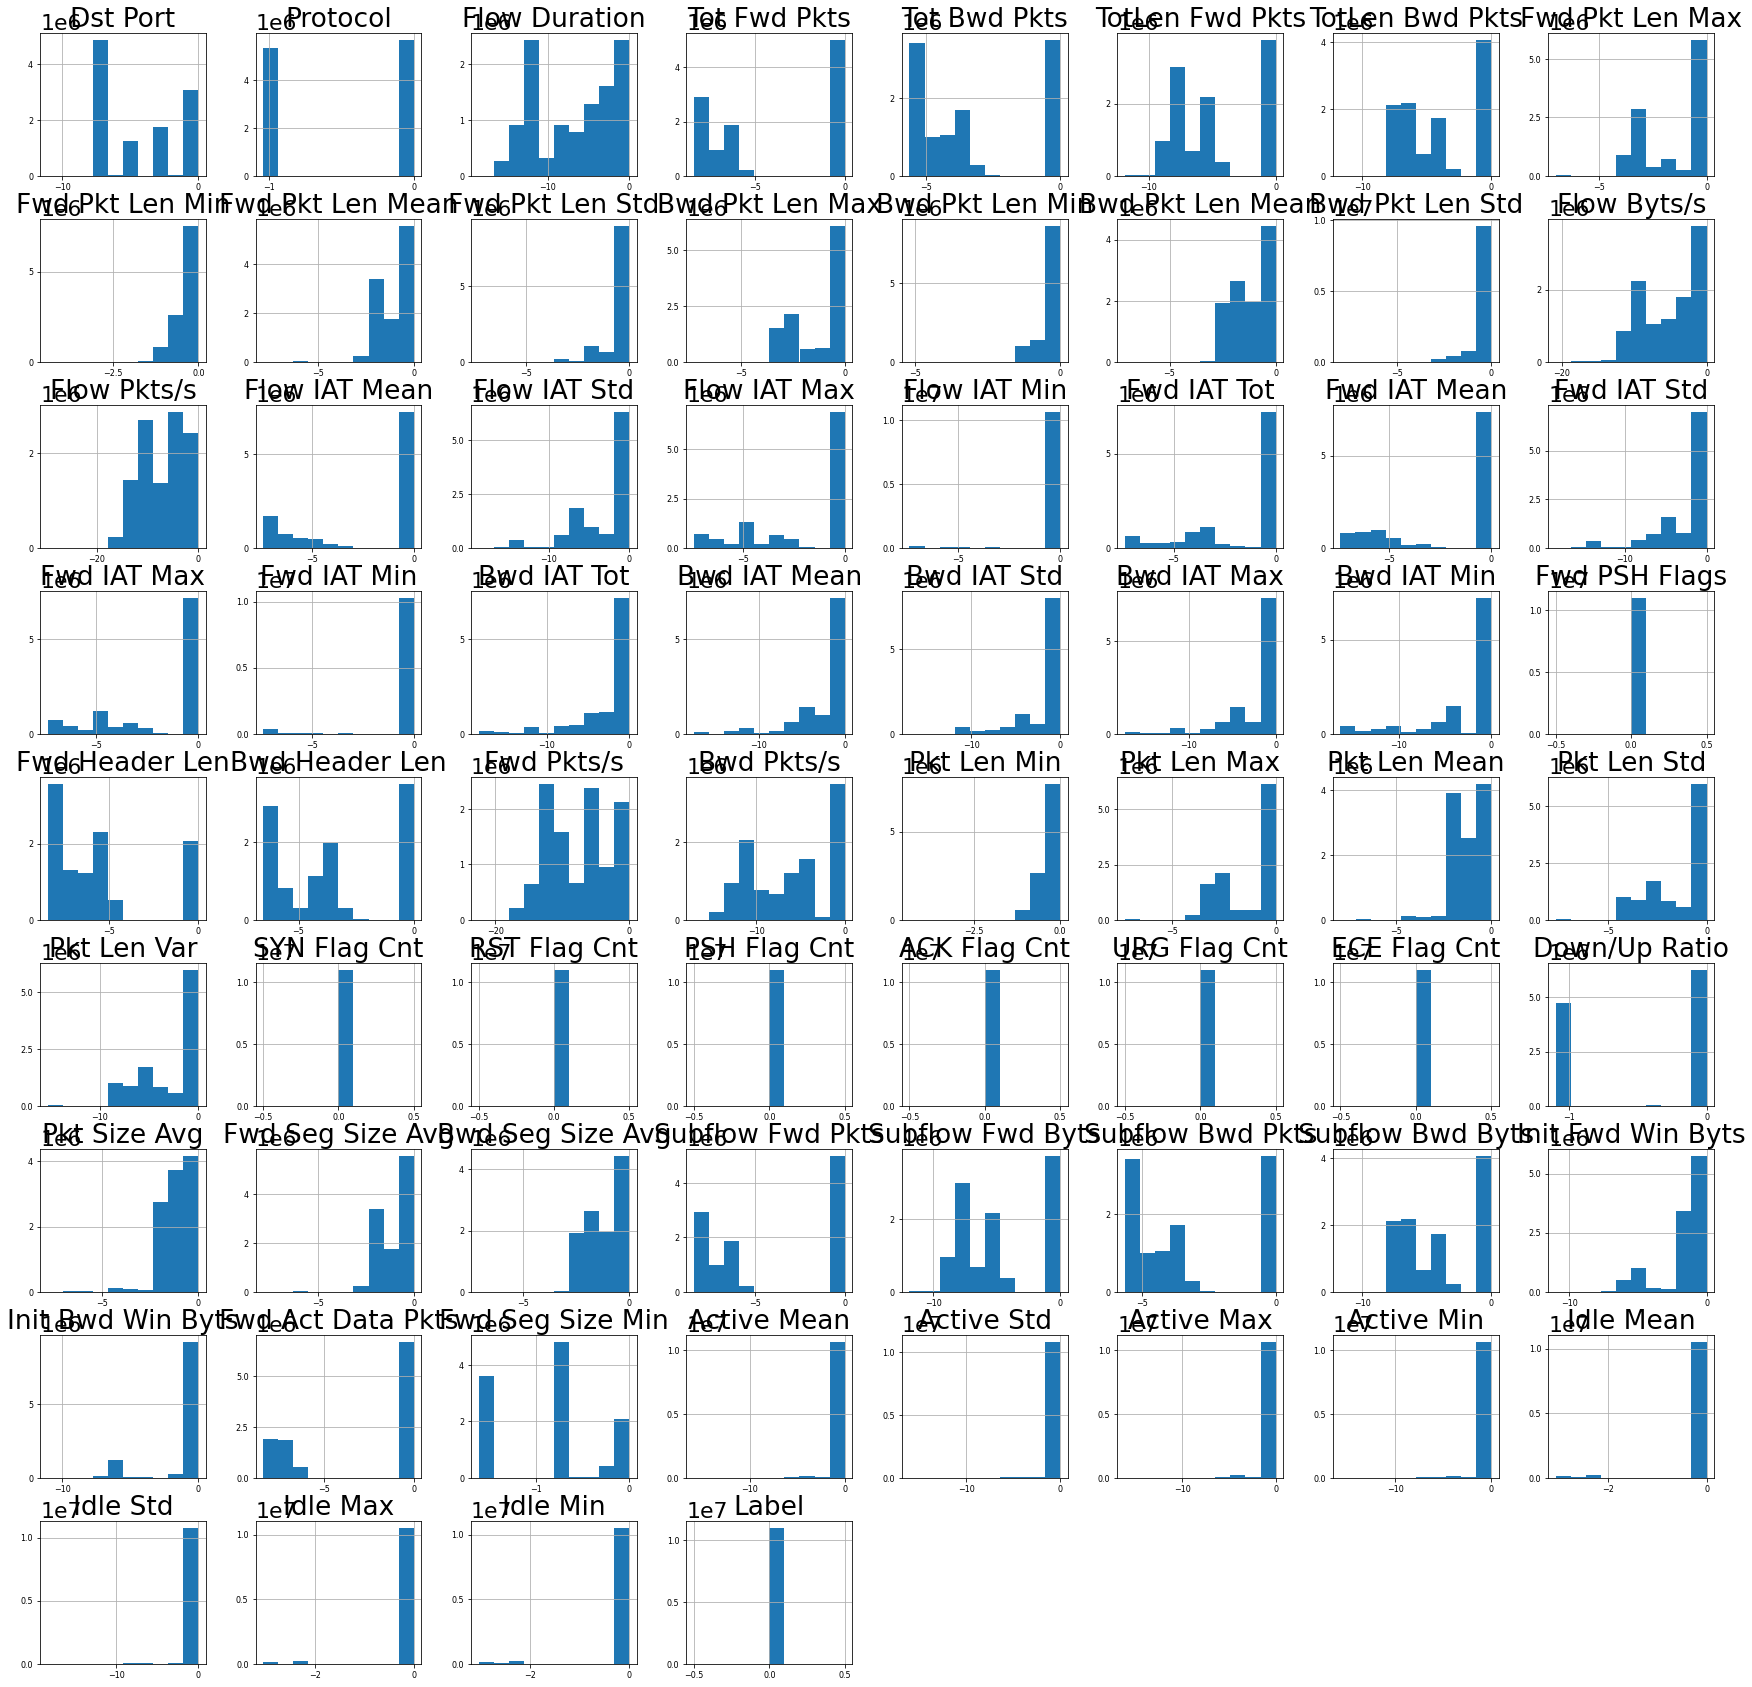

In [29]:
((pd.DataFrame(np.log(df.where(df['Label']==0)))).replace(-np.Inf,0)).hist(figsize=(30,30),xlabelsize=8,ylabelsize=8)

# Plotting the correlation matrix to check correlation between features

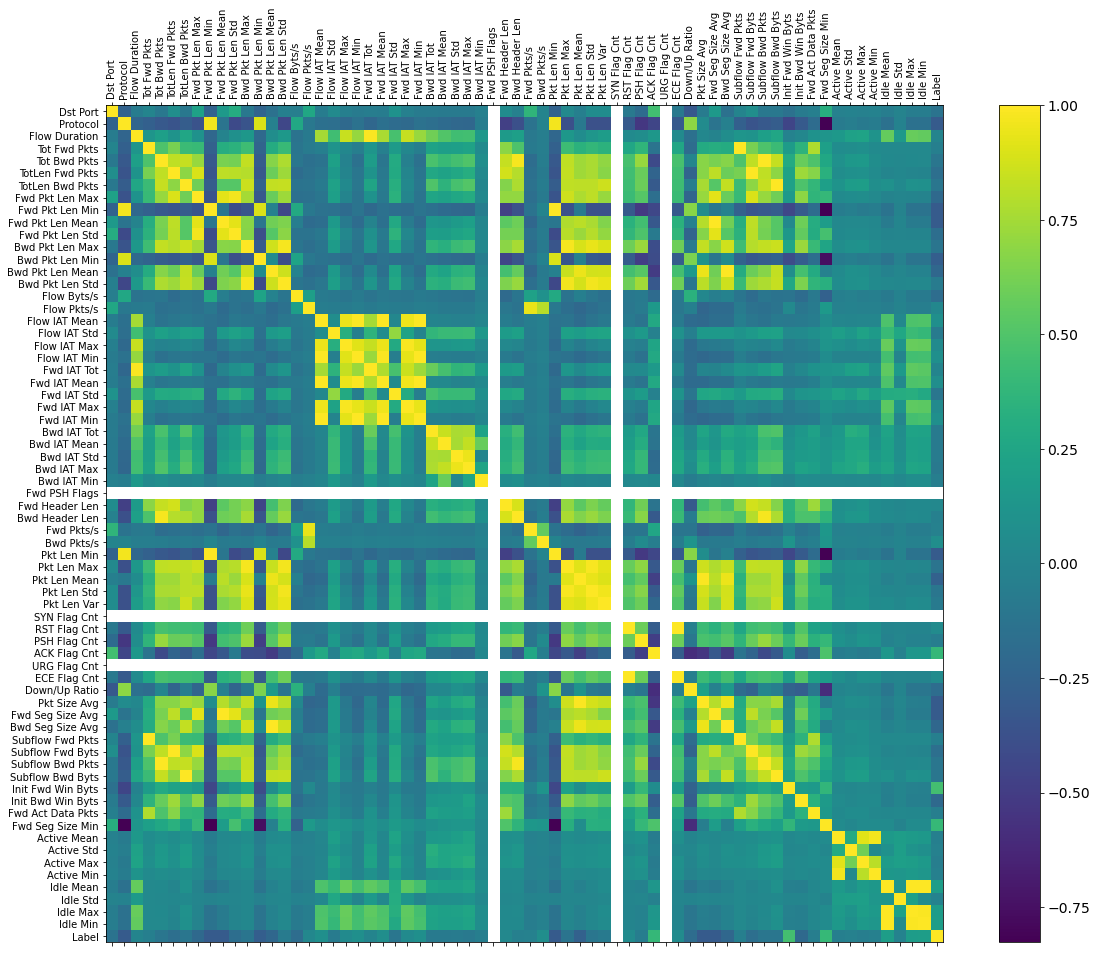

In [30]:
f = plt.figure(figsize=(20,15))
plt.matshow(df.corr(),fignum = f.number)
plt.xticks(range(df.shape[1]),df.columns,fontsize=10,rotation=90)
plt.yticks(range(df.shape[1]),df.columns,fontsize=10)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=14)



In [31]:
def identify_correlated(df, threshold):
    """
    A function to identify highly correlated features.
    """
    # Compute correlation matrix with absolute values
    matrix = df.corr().abs()
    
    # Create a boolean mask
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    
    # Subset the matrix
    reduced_matrix = matrix.mask(mask)
    
    # Find cols that meet the threshold
    to_drop = [c for c in reduced_matrix.columns if \
              any(reduced_matrix[c] > threshold)]
    
    return to_drop

In [32]:
to_drop = identify_correlated(df, threshold=.9)
print(len(to_drop))


29


In [33]:
to_drop = ['Protocol',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Mean',
 'Fwd IAT Max',
 'Bwd IAT Std',
 'Bwd Header Len',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'RST Flag Cnt',
 'Pkt Size Avg',
 'Active Mean',
 'Idle Mean',
 'Idle Max']

In [34]:
y = df['Label']

In [35]:
df = df.drop('Label',axis=1)

In [36]:
#Dropping these columns due to Nan values after standardisation
def dropingColumns(df):
    df = df.drop(to_drop,axis=1)
    df = df.drop('SYN Flag Cnt',axis=1)
    df = df.drop('URG Flag Cnt',axis=1)
    df = df.drop('Fwd PSH Flags',axis=1)
    return df
df = dropingColumns(df)    
dft = dropingColumns(dft) 

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11008504 entries, 0 to 15173221
Data columns (total 35 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           float32
 1   Bwd Pkt Len Min    float16
 2   Flow Byts/s        float64
 3   Flow IAT Std       float32
 4   Fwd IAT Tot        float32
 5   Fwd IAT Std        float32
 6   Fwd IAT Min        float32
 7   Bwd IAT Tot        float32
 8   Bwd IAT Mean       float32
 9   Bwd IAT Max        float32
 10  Bwd IAT Min        float32
 11  Fwd Header Len     float32
 12  Fwd Pkts/s         float32
 13  Bwd Pkts/s         float32
 14  Pkt Len Min        float16
 15  Pkt Len Var        float32
 16  PSH Flag Cnt       float64
 17  ACK Flag Cnt       float64
 18  ECE Flag Cnt       float64
 19  Down/Up Ratio      float16
 20  Fwd Seg Size Avg   float16
 21  Bwd Seg Size Avg   float16
 22  Subflow Fwd Pkts   float32
 23  Subflow Fwd Byts   float32
 24  Subflow Bwd Pkts   float32
 25  Subflow Bwd Byts

In [38]:
# dr = ["FIN Flag Cnt","CWE Flag Count","Fwd URG Flags"]
# dft = dft.drop(dr,axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11008504 entries, 0 to 15173221
Data columns (total 35 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           float32
 1   Bwd Pkt Len Min    float16
 2   Flow Byts/s        float64
 3   Flow IAT Std       float32
 4   Fwd IAT Tot        float32
 5   Fwd IAT Std        float32
 6   Fwd IAT Min        float32
 7   Bwd IAT Tot        float32
 8   Bwd IAT Mean       float32
 9   Bwd IAT Max        float32
 10  Bwd IAT Min        float32
 11  Fwd Header Len     float32
 12  Fwd Pkts/s         float32
 13  Bwd Pkts/s         float32
 14  Pkt Len Min        float16
 15  Pkt Len Var        float32
 16  PSH Flag Cnt       float64
 17  ACK Flag Cnt       float64
 18  ECE Flag Cnt       float64
 19  Down/Up Ratio      float16
 20  Fwd Seg Size Avg   float16
 21  Bwd Seg Size Avg   float16
 22  Subflow Fwd Pkts   float32
 23  Subflow Fwd Byts   float32
 24  Subflow Bwd Pkts   float32
 25  Subflow Bwd Byts

In [39]:
#Feature Selection by Chi2 Test , lower the value more important the feature
df.describe()

,Dst Port,Bwd Pkt Len Min,Flow Byts/s,Flow IAT Std,Fwd IAT Tot,Fwd IAT Std,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Max,Bwd IAT Min,Fwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Var,PSH Flag Cnt,ACK Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Std,Active Max,Active Min,Idle Std,Idle Min
count,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07,1.100850e+07
mean,8.494320e-02,NaN,7.802658e-03,4.779287e-03,3.218153e-02,4.610639e-03,1.504438e-02,1.899883e-02,1.776449e-02,1.965338e-02,4.463757e-03,2.258971e-03,7.317188e-03,5.694646e-03,NaN,8.163076e-02,3.710142e-01,2.895862e-01,1.688607e-01,NaN,NaN,NaN,6.271499e-04,2.105832e-03,1.016094e-02,4.249786e-03,8.762153e-02,1.536586e-01,3.307697e-04,NaN,1.158834e-03,2.948326e-03,3.008656e-03,2.961515e-04,9.703341e-03
std,2.246842e-01,0.000000e+00,1.917233e-02,2.033017e-02,1.053287e-01,1.772157e-02,7.923765e-02,8.302305e-02,6.096205e-02,5.996840e-02,3.998747e-02,2.848652e-03,2.776986e-02,4.189431e-02,0.000000e+00,1.433314e-01,4.830763e-01,4.535703e-01,3.746289e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.540244e-03,3.486654e-03,1.294123e-02,7.952378e-03,1.364997e-01,3.443035e-01,1.076994e-03,0.000000e+00,1.994021e-02,2.823496e-02,3.487574e-02,8.048411e-03,5.000274e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.152091e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.244669e-04,5.319618e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.999512e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.230504e-03,0.000000e+00,9.750456e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.122335e-03,1.007670e-04,1.574979e-05,0.000000e+00,2.992880e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.635742e-01,1.137695e-01,2.245173e-04,2.946128e-04,3.623188e-03,8.408919e-04,4.824295e-03,0.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.212723e-02,3.408203e-01,6.713306e-03,3.248789e-03,1.557632e-02,1.510666e-03,0.000000e+00,5.658489e-03,1.171713e-02,6.028253e-03,2.466102e-05,3.703704e-03,3.378358e-03,2.359882e-03,4.487305e-01,1.132032e-01,1.000000e+00,1.000000e+00,0.000000e+00,3.332520e-01,2.885742e-01,2.291260e-01,8.980692e-04,2.616442e-03,1.449275e-02,3.984031e-03,1.421605e-01,3.219654e-03,2.245173e-04,5.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e

In [40]:
# Feature Selection using chi2 test
# Chi2 test is used to test independence of two events
score = chi2(df,y)

In [41]:

score


(array([1.10914669e+05, 3.63434443e+05, 1.54254302e+04, 4.29035420e+03,
        9.41153546e+01, 8.48254443e+03, 3.42430797e+04, 2.82362104e+04,
        1.43047437e+04, 1.57507882e+04, 9.11877150e+03, 2.23663016e+01,
        5.29143283e+02, 2.06944183e+04, 3.61742982e+05, 1.69045946e+04,
        2.09250455e+04, 1.17349236e+06, 2.54372796e+04, 5.85689183e+04,
        2.40507760e+05, 9.39333677e+04, 6.41553465e+01, 1.68098158e+03,
        2.25245424e+03, 1.91017844e+03, 4.88903634e+05, 3.43341401e+05,
        8.04113737e+01, 1.48437714e+05, 2.48641518e+03, 5.26175741e+03,
        4.81391147e+03, 5.36950155e+02, 1.02223253e+05]),
 array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        2.97661284e-022, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 2.25292554e-006,
        4.33843017e-117, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.0

In [42]:
df.columns

Index(['Dst Port', 'Bwd Pkt Len Min', 'Flow Byts/s', 'Flow IAT Std',
       'Fwd IAT Tot', 'Fwd IAT Std', 'Fwd IAT Min', 'Bwd IAT Tot',
       'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len',
       'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Var',
       'PSH Flag Cnt', 'ACK Flag Cnt', 'ECE Flag Cnt', 'Down/Up Ratio',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Active Std', 'Active Max', 'Active Min',
       'Idle Std', 'Idle Min'],
      dtype='object')

In [43]:
#We are considering here p_values which gives us probability that variables are independent
p_values = pd.Series(score[1],index = df.columns)
p_values.sort_values(ascending = True,inplace = True)
p_values

Dst Port              0.000000e+00
Active Min            0.000000e+00
Active Max            0.000000e+00
Active Std            0.000000e+00
Fwd Seg Size Min      0.000000e+00
Init Bwd Win Byts     0.000000e+00
Init Fwd Win Byts     0.000000e+00
Subflow Bwd Byts      0.000000e+00
Subflow Bwd Pkts      0.000000e+00
Subflow Fwd Byts      0.000000e+00
Bwd Seg Size Avg      0.000000e+00
Fwd Seg Size Avg      0.000000e+00
Down/Up Ratio         0.000000e+00
ECE Flag Cnt          0.000000e+00
PSH Flag Cnt          0.000000e+00
ACK Flag Cnt          0.000000e+00
Pkt Len Min           0.000000e+00
Bwd Pkt Len Min       0.000000e+00
Flow Byts/s           0.000000e+00
Flow IAT Std          0.000000e+00
Fwd IAT Std           0.000000e+00
Fwd IAT Min           0.000000e+00
Pkt Len Var           0.000000e+00
Bwd IAT Mean          0.000000e+00
Bwd IAT Tot           0.000000e+00
Bwd IAT Min           0.000000e+00
Bwd Pkts/s            0.000000e+00
Bwd IAT Max           0.000000e+00
Idle Min            

In [44]:
dropBychi2 = ['Fwd Pkts/s','Idle Std','Fwd IAT Tot','Fwd Act Data Pkts','Subflow Fwd Pkts','Fwd Header Len']
df = df.drop(dropBychi2,axis=1)
dft = dft.drop(dropBychi2,axis=1)

In [45]:
df.to_csv('myTrain.csv',index=False)

In [46]:
dft.to_csv('myTest.csv',index=False)

In [47]:
y.to_csv('labels.csv',index=False)

# Train Test and Split

In [48]:
from sklearn.model_selection import train_test_split
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(df, y, test_size = .20, stratify=y,random_state=45)

In [49]:
X_train_val.shape
y_train_val.shape

(8806803,)

In [50]:
y.shape

(11008504,)

In [51]:
#Garbage collection
#del df
import gc
gc.collect()

366

# Training model and hyperparameter tuning

In [52]:
import dask
import joblib
from dask.distributed import Client
client = Client(processes=False)
client



Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://172.19.2.2:8787/status,
Dashboard: http://172.19.2.2:8787/status,Workers: 1
Total threads: 4,Total memory: 31.36 GiB
Status: running,Using processes: False
Comm: inproc://172.19.2.2/17/1,Workers: 1
Dashboard: http://172.19.2.2:8787/status,Total threads: 4
Started: Just now,Total memory: 31.36 GiB
Comm: inproc://172.19.2.2/17/4,Total threads: 4
Dashboard: http://172.19.2.2:40699/status,Memory: 31.36 GiB
Nanny: None,


In [53]:
X_train, X_test, y_train, y_test = dask.persist(X_train_val, X_test_val, y_train_val, y_test_val)

# Multinomial NaiveBayes (took less than 1 minute to fit and predict)

In [54]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB(alpha=1)
inc = Incremental(model, scoring='f1')
classes=[0,1]
inc.fit(X_train, y_train, classes=classes)
inc.score(X_test, y_test)
arr = inc.predict(dft)
for _ in range(10):
    inc.partial_fit(X_train, y_train, classes=classes)
    print('Score:', inc.score(X_test, y_test))
a = np.unique(arr,return_counts=True)
a
my_df = pd.DataFrame(arr)
my_df.to_csv('mnb5.csv',index= True,index_label='index',)
my_df.columns=['Label']
from IPython.display import FileLink
FileLink(r'mnb5.csv')

Score: 0.6054137127434669
Score: 0.6054137127434669
Score: 0.6054137127434669
Score: 0.6054137127434669
Score: 0.6054137127434669
Score: 0.6054137127434669
Score: 0.6054137127434669
Score: 0.6054137127434669
Score: 0.6054137127434669
Score: 0.6054137127434669


/kaggle/working/mnb5.csv

In [55]:
inc.get_params()

{'assume_equal_chunks': True,
 'estimator__alpha': 1,
 'estimator__class_prior': None,
 'estimator__fit_prior': True,
 'estimator': MultinomialNB(alpha=1),
 'predict_meta': None,
 'predict_proba_meta': None,
 'random_state': None,
 'scoring': 'f1',
 'shuffle_blocks': True,
 'transform_meta': None}

# Logistic Regression

In [56]:
# #Logistic Regression using dask as a parallel processing
# from sklearn.linear_model import LogisticRegression
# lr = LogisticRegression(solver='saga', max_iter=1000, n_jobs=-1,penalty='l1',C=0.1)
# with joblib.parallel_backend("dask"):
#     lr.fit(X_train_val, y_train_val)
# y_val_preds = lr.predict(X_test_val)  
# from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, confusion_matrix, precision_recall_curve, PrecisionRecallDisplay
# print("Accuracy: {},Precision: {}, Recall: {}, F2 Score: {}".format(accuracy_score(y_test_val, y_val_preds),precision_score(y_test_val, y_val_preds), recall_score(y_test_val, y_val_preds), fbeta_score(y_test_val, y_val_preds, beta=2.0)))

# y_val_preds = lr.predict(dft) 
# my_df = pd.DataFrame(y_val_preds)
# my_df.to_csv('logis5.csv',index= True)
# from IPython.display import FileLink
# FileLink(r'logis5.csv')

# #F1 score of 0.87 on cross validation
# #F1 score of 0.35 on actual test data

# Bernoulli

In [57]:
# #Bernoulli 
# from sklearn.naive_bayes import BernoulliNB
# model = BernoulliNB(alpha=100,binarize=0.4)
# inc = Incremental(model, scoring='f1')
# classes=[0,1]
# inc.fit(X_train, y_train, classes=classes)
# inc.score(X_test, y_test)

# arr = inc.predict(dft)
# a = np.unique(arr,return_counts=True)
# a
# my_df = pd.DataFrame(arr)
# my_df.to_csv('ber3.csv',index= True,index_label='index',)
# my_df.columns=['Label']
# from IPython.display import FileLink
# FileLink(r'ber3.csv')

# #F1 score of 0.711 on cross validation
# # F1 score of 0.4646 on test data

# Passive Aggressive Classifier

In [58]:
# #Passive aggressive classifier
# from sklearn.linear_model import PassiveAggressiveClassifier
# model = PassiveAggressiveClassifier(loss='hinge',max_iter=1000,tol=1e-2,C=1,shuffle=True,random_state=2)
# inc = Incremental(model, scoring='f1')
# classes=[0,1]
# inc.fit(X_train, y_train, classes=classes)
# inc.score(X_test, y_test)

# arr = inc.predict(dft)

# my_df = pd.DataFrame(arr)
# my_df.to_csv('pac1.csv', index= True)
# from IPython.display import FileLink
# FileLink(r'pac1.csv')

# #F1 score of 0.85 on cross validation
# # F1 score of 0 

# SGD Classifier

In [59]:
# from sklearn.linear_model import SGDClassifier
# model = SGDClassifier(loss='hinge', penalty='l2',alpha=0.001, tol=1e-4,n_jobs=-1,learning_rate='optimal')
# inc = Incremental(model, scoring='f1')
# classes=[0,1]
# inc.fit(X_train, y_train, classes=classes)
# inc.score(X_test, y_test)
# for _ in range(10):
#     inc.partial_fit(X_train, y_train, classes=classes)
#     print('Score:', inc.score(X_test, y_test))
    
    
# arr = inc.predict(dft)
# my_df = pd.DataFrame(arr)
# my_df.to_csv('sgd3.csv', index= True)
# from IPython.display import FileLink
# FileLink(r'sgd3.csv')    
# # Accuracy of SGD calssifier = 0.9372071866252502

# Perceptron

In [60]:
#  model = Perceptron(penalty='l1',alpha=0.0001, max_iter=10000,tol=1e-3,n_jobs=-1,
# warm_start=True,fit_intercept=True)
# inc = Incremental(model, scoring='f1')
# classes=[0,1]
# inc.fit(X_train, y_train, classes=classes)
# inc.score(X_test, y_test)

# for _ in range(10):
#     inc.partial_fit(X_train, y_train, classes=classes)
#     print('Score:', inc.score(X_test, y_test))
# #Accuracy of Perceptron = 0.934705030337907

# XGBoost

In [2]:
# import xgboost as xgb
# import dask.distributed

# if __name__ == "__main__":
#     cluster = dask.distributed.LocalCluster()
#     client = dask.distributed.Client(cluster)

#     dtrain = xgb.dask.DaskDMatrix(client, X_train, y_train)

#     output = xgb.dask.train(
#         client,
#         {"verbosity": 2, "tree_method": "hist",
#          "objective": "reg:squarederror"},
#         dtrain,
#         num_boost_round=4,
#         evals=[(dtrain, "train")],
#     )